# This is the notebook for the project of Applied Data Analysis.

### This project is based on the data of the openfood dataset found on https://world.openfoodfacts.org/data 

The goal of this notebook is the following:

1) Learn to handle the datas that we use

2) Understand the format of the datas (and also clean them)

3) Visualize and learn from the datas:

    A) The quantity of sugar in the product depending on the country
    
    B) The number of products that are vegetables


#### First we need to import every library we will need and import the datas

In [1]:
# Put your imports here.
import os
import pandas as pd
import json
import folium
import numpy as np
from datetime import datetime, date, time
import dateutil.parser
import matplotlib.pyplot as plt
import collections
import branca.colormap as cm
from branca.element import Template, MacroElement

# WARNING : Make sure that Seaborn is updated (0.9.0) on your computer !
import seaborn as sns

Now we load the datas from the csv file

In [2]:
DATAPATH = "./data/"

First of all, we will not need all the columns in the dataset, so instead of loading all of them, we only keep the ones that are useful for us and that contains enough informations. Those columns are 'url', 'creator', 'created_t', 'last_modified_t', 'product_name', 'generic_name', 'quantity', 'brands', 'labels', 'stores','countries','ingredients_text', 'additives', 'nutrition_grade_fr', 'pnns_groups_1','pnns_groups_2', 'main_category', 'main_category_en'.

We also need to load the nutriments in an other table in order to have this information directly available. 

In [3]:
food = pd.read_csv(DATAPATH+"openfoodfacts.csv", sep = '\t', low_memory = False,
                   usecols = ['code','url', 'creator', 'created_t', 'last_modified_t', 'product_name',
                   'generic_name', 'quantity', 'brands', 'labels_en', 'stores', 'countries_en',
                   'ingredients_text', 'additives', 'nutrition_grade_fr', 'pnns_groups_1',
                   'pnns_groups_2', 'main_category_en'])

In [4]:
nutriments = pd.read_csv(DATAPATH+"openfoodfacts.csv", sep = '\t', low_memory = False,
                   usecols = lambda c: "_100g" in c)

In [5]:
# We also add the column "code" to the nutriment dataFrame
nutriments['code'] = food.code

We also create a variable containing the json file that we will use later on for the visualization.

In [32]:
geo_json_data = DATAPATH + "world-countries.json"

### food dataframe cleaning

As an introduction, let's describe the columns that we kept:

1) code: barcode of the product. Useful to join the tables of food and nutriments

2) url: the url of the product on OpenFoodFact

3) creator: the creator of the page for the product on OpenFoodFact

4) created_t: date of creation of the product

5) last_modified_t: the last modification of the product page

6) product_name: name of the product

7) generic_name: a more general name

8) quantity: the size of the packaging

9) brands

10) labels: labels of the product (bio,...)

11) stores: where you can buy the product

12) country: name of the country in which you can buy the product (one row per country)

13) ingredient_text: the ingredients of the product

14) additives

15) nutrition_grade: a grade from "A" to "E" with "A" healthy and "E" not healthy

16) pnns_groups_1: type of food

17) pnns_groups_2: type of food but not same as groups_1

18) main_category: in which category is the product

Just to be sure, we remove the columns and lines that contain only na values

In [43]:
food.dropna(how="all",inplace = True)
food.dropna(how="all",axis=1,inplace=True)

We first need to remove the lines where the values are not well entered. To do so, we check if the column `url` contains bad values. 

We consider as a bad value a line where the url doesn't contains a "/" inside, meaning that it is not a url...

In [7]:
bad_indices = food.url.str.contains("/")
bad_array = np.array(bad_indices)
bad_index = np.where(bad_array != True)

We now need to check what are those odd values. It turns out it is nan values... The corresponding lines weren't well completed... So we can remove them

In [8]:
food.take(bad_index[0]).head()

,code,url,creator,created_t,last_modified_t,product_name,generic_name,quantity,brands,labels_en,stores,countries_en,ingredients_text,additives,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,main_category_en
264660,NaN,NaN,villecomtal-sur-arros-gers-france,"Puygouzon,France",France,France,"Yaourt (_Lait_), sucre 8,2 %, fraise 5 %, épai...",en:milk,NaN,NaN,Milk and yogurt,"To be completed,Nutrition facts completed,Ingr...",en:dairies,2.9,NaN,NaN,NaN,NaN
264713,NaN,NaN,"villecomtal-sur-arros-gers-france,saint-just-c...","Saint-Priest,France",France,France,"_Lait_ entier (59.5 %), _lait_ écrémé concentr...",en:milk,NaN,NaN,Milk and yogurt,"To be checked,Complete,Nutrition facts complet...",en:dairies,2.9,NaN,NaN,NaN,NaN
264743,NaN,NaN,villecomtal-sur-arros-gers-france,France,"Belgique,France","Belgium,France","Lait entier, fruits : fraise (20 %), mangue (1...",NaN,NaN,NaN,Milk and yogurt,"To be completed,Nutrition facts completed,Ingr...",en:dairies,3.2,NaN,NaN,NaN,NaN
264780,NaN,NaN,"villecomtal-sur-arros-gers-france,saint-just-c...","Villecresnes,Villeurbanne,France",France,France,"_Lait_ entier (59,5 %), _lait_ écrémé concentr...","Lait, lait, crème",NaN,NaN,Milk and yogurt,"To be checked,Complete,Nutrition facts complet...",en:dairies,2.9,NaN,NaN,NaN,NaN
264786,NaN,NaN,villecomtal-sur-arros-gers-france,France,"Belgique,France, en:switzerland","Belgium,France,Switzerland","Lait entier 69.5 %, fruits : fraise 10 %, mang...",NaN,NaN,NaN,Milk and yogurt,"To be checked,Complete,Nutrition facts complet...",en:dairies,3.2,NaN,NaN,NaN,NaN


In [9]:
food.drop(bad_index[0], inplace=True)

We now need to transform the columns containing time. To do so, we know (from the description of the columns given on openfoodfacts) that the columns starting ending with a certain suffix are the one containing dates:

1) datetime : yyyy-mm-ddThh:mn:ssZ

2) t : unix timestamp

There is only 4 columns respectings one of the two conditions, namely `created_t`, `created_datetime`, `last_modified_t` and `last_modified_datetime`. We already removed the `_datetime` one since it is only an other format for the `_t` columns. So we can apply the function of pandas: **to_datetime()**

In [10]:
food.created_t = pd.to_datetime(food.created_t,unit='s')
food.last_modified_t = pd.to_datetime(food.last_modified_t,unit='s')

We will also replace the nan values in the columns `pnns_groups_1` and `pnns_groups_2` by the value unknow since if it's na, it means that either it is unknown or either it's forgotten by the user who gave the product

In [11]:
food.pnns_groups_1.replace(to_replace=np.nan, value="unknown",inplace=True)
food.pnns_groups_2.replace(to_replace=np.nan, value="unknown",inplace=True)

We still need to rename the columns with the en suffix. This is easily done with pandas

In [12]:
food = food.rename(index=str, columns={"countries_en": "countries", "labels_en": "labels","main_category_en":"main_category","nutrition_grade_fr":"nutrition_grade"})

We also need to split countries that have a "," inside meaning that it is more than one country and also need to put a capital letter to every countries and remove the "fr/en/ch:" in front of some countries (some users didn't use a good format...). Also we had to correct some country names so that they match the ones in the json file that we will use for visualization. 

In [13]:
def cleaningCountries(c:str)->list:
    """
    This function helps cleaning the names of the countries.
    Input: 
        c(string): contains the list of the countries separated with a comma
    Ouput:
        cleaned(list): contains the name of the countries cleaned and without duplicates and with a capital letter
    """
    cList = c.split(",")
    cleaned = []
    for element in cList:
        if (":" in element): # To clean element of the form "fr/en/ch:name_countries"
            element = element[3::]
            element = element.title()
            if (element == "Deutschland" or element=="Allemagne"):
                element = "Germany"
            elif (element == "Frankreich"):
                element = "France"
            elif (element == "Suisse" or  element == "Schweiz"):
                element = "Switzerland"
            elif (element == "Espagne"):
                element = "Spain"
            elif (element == "Belgique"):
                element = "Belgium"
            elif (element == "Japon"):
                element = "Japan"
            elif (element == "Russie"):
                element = "Russia"
            elif (element == "Serbie"):
                element = "Republic of Serbia"
            elif (element == "Serbia"):
                element = "Republic of Serbia"
            elif (element == "Quebec"):
                element = "Canada"
            elif ("And" in element):
                elment = "and".join(element.split("And"))
            elif ("Of" in element):
                elment = "of".join(element.split("Of"))
            elif (len(element) > 2):
                pass
            else:
                continue
        else:
            element = element.title()
            if (element == "Allemagne"):
                element = "Germany"
            elif (element == "Espagne"):
                element = "Spain"
            elif (element == "Belgique"):
                element = "Belgium"
            elif (element == "Japon"):
                element = "Japan"
            elif (element == "Russie"):
                element = "Russia"
            elif (element == "Serbie"):
                element = "Serbia"
            elif (element == "Quebec"):
                element = "Canada"
            elif (element == "Serbia"):
                element = "Republic of Serbia"
            elif (element == "United States"):
                element = 'United States of America'
            elif (element == 'Grece'):
                element = 'Greece'
            elif (element == 'European Union'):
                continue
            elif ("And" in element):
                element = "and".join(element.split("And"))
                if ("The" in element):
                    element = "the".join(element.split("The"))
            elif ("Of" in element):
                element = "of".join(element.split("Of"))
                if ("The" in element):
                    element = "the".join(element.split("The"))
            elif (len(element) > 2):
                pass
            else:
                continue
        cleaned.append(element)
    
    return list(set(cleaned))

In [14]:
food.countries = food.countries.map(lambda c: cleaningCountries(c), na_action = 'ignore')

### nutriments dataframe cleaning

Now we need to see if the nutriments that we loaded have enough infos inside. Let's look inside!

In [15]:
nutriments.head()

,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,...,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,code
0,1569.0,NaN,7.0,3.08,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000000000017
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000000000031
2,88.0,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000000000123
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000000000018
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000000000019


We notice that there are some rows that only contains nan values. Thus we need to remove those lines, since we can get any infos about them...

In [16]:
nutriments.dropna(how="all",inplace = True)
nutriments.dropna(how="all",axis=1,inplace=True)

In [17]:
nutriments.head()

,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,...,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,code
0,1569.0,NaN,7.0,3.08,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000000000017
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000000000031
2,88.0,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000000000123
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000000000018
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000000000019


In order to see if there is not too less informations in the columns, we can use the next function that compute the percentage of values that we can use in a column. 

We can then apply this function to the columns that we have and see if we should keep them or not...

In [18]:
def percentageNonNa(data):
    """
    input:
        data: column of a dataframe
    output:
        percentage of non-na values.
    """
    return 100*(len(data)-np.sum(data.isnull()))/len(data)

In [19]:
nutriments_percentage = nutriments.apply(lambda c: percentageNonNa(c))
nutriments_percentage = np.array(nutriments_percentage)
nutriments_keep_index = np.where(nutriments_percentage > 40)
cols_to_remove = nutriments.columns[~nutriments.columns.isin(nutriments.columns[nutriments_keep_index[0]])].values

We can now drop the columns that contains less than **40%** of useful informations, ie contains more than 60% of nan values

In [20]:
nutriments.drop(columns = cols_to_remove,inplace = True)

In [21]:
nutriments.head()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,code
0,1569.0,7.0,3.08,70.1,15.0,7.8,1.40,0.551181,0000000000017
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000000000031
2,88.0,0.0,0.00,4.8,0.4,0.2,2.04,0.803150,0000000000123
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000000000018
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000000000019


We still notice one small problem... We still need to remove the lines where everything is nan exept the column code.

In [22]:
nutriments.dropna(axis=0, how='all', thresh=len(nutriments.columns),inplace = True)

Now everything is cleaned and we can start the second part, namely the first vizualisations of the datas!

### Vizualisations of the datas

We will first merge the two dataframes (**nutriments** and **food**). Doing this avoid computing values in one of the table but this entry doesn't exist in the other dataframe. We still keep a copy of the two dataframe separate since this could be useful if we want to compute some values in one of the two dataframe but we don't need the other one.

In [23]:
Complete = pd.merge(food,nutriments,how='inner',on='code')

Then we need to have a row for every countries and not a list of countries, so we need to apply some pandas magic ;)

In [24]:
Complete_cleaned = Complete.countries.apply(pd.Series) \
    .merge(Complete, right_index = True, left_index = True) \
    .drop(["countries"], axis = 1) \
    .melt(id_vars = Complete.columns.values[np.where(Complete.columns.values != 'countries')], value_name = "country")\
    .drop("variable", axis = 1)\
    .dropna()

First visualization, we can see which countries consumes the most sugar per 100 g in there products. We can use the columns `countries` and the column `sugars_100g` to do that.

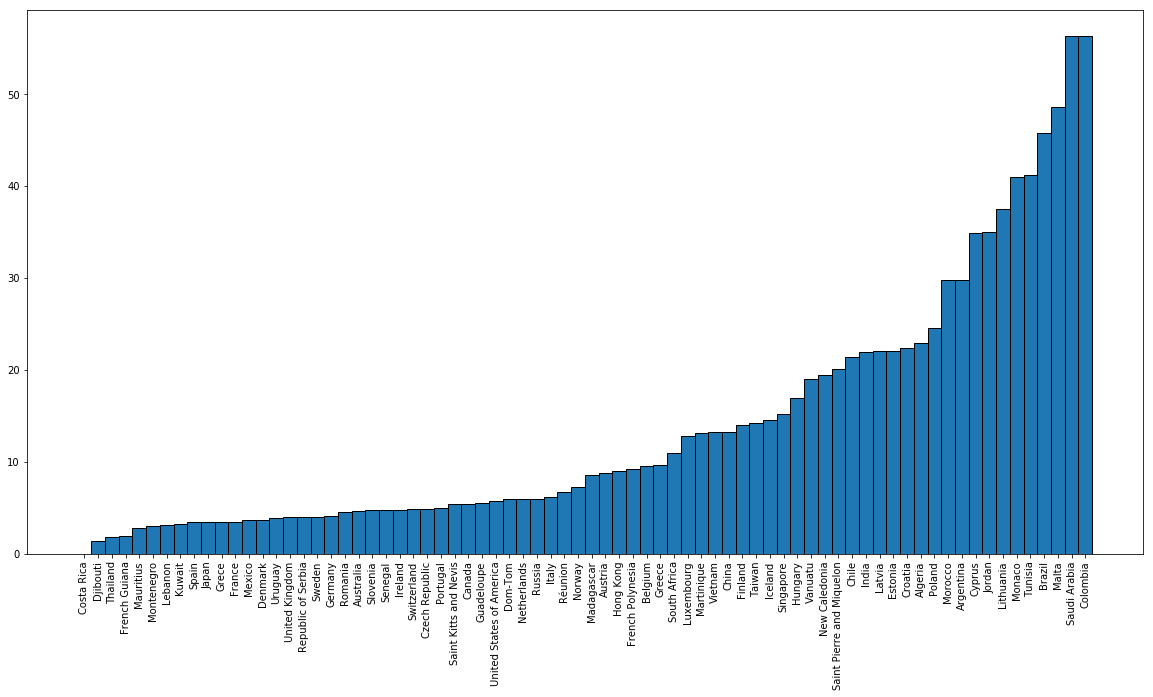

In [25]:
median_sugar = Complete_cleaned.groupby("country").median().sugars_100g
median_sugar = median_sugar.sort_values()

fig,ax = plt.subplots(figsize=(20, 10))
ax.bar(median_sugar.index,median_sugar.values, align='center', width=1,log=False,edgecolor = "black")
plt.xticks(rotation=90);

In [26]:
print("The percentage of country with a median product containing more than 25g of sugar is "+ \
        str(100*np.sum(median_sugar>=25)/len(median_sugar))+"%")
print("The percentage of country with a median product containing more than 10g of sugar is "+ \
        str(100*np.sum(median_sugar>=10)/len(median_sugar))+"%")

The percentage of country with a median product containing more than 25g of sugar is 14.8648648649%
The percentage of country with a median product containing more than 10g of sugar is 41.8918918919%


With the previous histogram, we can directly say some stuff.

First of all, we notice that the countries in South-America and in the Arab countries. Secondly we also notice that the European countries tend to eat less sugar per 100g in the products sell in those countries. 

Finally, we also notice that the median percent of sugar in the different products is above the 25g of sugar per days. This is the case in approximately 15% of the countries around the world. It is huge, knowing that it is for only one product. This percent get up to more than 40% if we take the products with more than 10g inside. This seems to show that we eat too much sugar!


In [27]:
# We create a dataframe from the previous pandas Series
median_sugar_df = pd.DataFrame({'country':median_sugar.index, 'sugars_100g':median_sugar.values})

In [28]:
def AddMissingCountries(df,fileJson,p):
    
    """
    This add the missing countries for a given property. This function can be reuse for other visualizations
    Input: 
        df: a dataframe in which we must add the missing countries
        fileJson: a json file containing all the name of all the countries
        p: the property we want to fill in string format
    Output:
        a dataframe with the good format.
    """
    
    with open(fileJson) as f:
        data = json.load(f)
    feat = data['features']
    for fe in feat:
        prop = fe['properties']
        name = prop['name']
        if (name not in df.country.values):
            df = df.append({'country':name,p:-1},ignore_index=True)
    return df

In [29]:
median_sugar_df = AddMissingCountries(median_sugar_df,DATAPATH+"world-countries.json","sugars_100g")

In [30]:
def plot_choropleth(data_dict, legend, min_val, max_val, color_steps=6):
    # Create a Folium Map of the World
    world = folium.Map(location=[30, 0], tiles='cartodbpositron', zoom_start=1.5)

    # Add color range
    linear = folium.branca.colormap.LinearColormap(['white','yellow','red'], vmin=min_val, vmax=max_val)
    linear = linear.to_step(color_steps)
    
    # Plot custom choropleth map    
    folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor':'black' if data_dict[feature['properties']['name']] == -1 else linear(data_dict[feature['properties']['name']]),
        'color': 'black',
        'weight': 1
    }
    ).add_to(world)
    
    # Add legend for color range
    linear.caption = legend
    world.add_child(linear)


    # Add a legend for cantons with no data
    template = """
    {% macro html(this, kwargs) %}

    <!doctype html>
    <html lang="en">
    <head>
      <meta charset="utf-8">
      <meta name="viewport" content="width=device-width, initial-scale=1">
      <title>jQuery UI Draggable - Default functionality</title>
      <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">
      <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
      <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
    </head>
    <body>
    <div id='maplegend' class='maplegend' 
        style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
         border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>     
    <div class='legend-scale'>
      <ul class='legend-labels'>
        <li><span style='background:grey;opacity:0.8;'></span>Countries for which no data was available</li>
      </ul>
    </div>
    </div>
    </body>
    </html>
    <style type='text/css'>
      .maplegend .legend-scale ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale ul li {
        font-size: 80%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels li span {
        display: block;
        float: left;
        height: 16px;
        width: 30px;
        margin-right: 5px;
        margin-left: 0;
        border: 1px solid #999;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }
    </style>
    {% endmacro %}"""

    macro = MacroElement()
    macro._template = Template(template)

    world.get_root().add_child(macro)

    return world

In [33]:
median_sugar_dict = median_sugar_df.set_index('country')['sugars_100g']
world = plot_choropleth(median_sugar_dict, 'Quantity of sugar per 100g', 0, max(median_sugar_df["sugars_100g"]),10)

world

Seeing the previous map, we can say multiple things:

1) There are a lot of missing values... Those missing values are manely in the south part of the world (e.g. Africa) This could be explain by the fact that there are a lot of poor countries and inform about the product on their country is not their main focus. It could also be explained by the fact that the website OpenFoodFact seems to be more an european thing, mostly because it was created by a french programmer in 2012.

2) The sugar is more present in the countries in the south (even if it is not necessarly those countries that have the most entries in the dataset). The sugar is also present in the Arabic country, maybe reflecting the food culture, in which they use more sweet recipes.

3) Europe doesn't have the most sugar in their product. This could be explain by the fact that maybe the european countries begin to understand that too much sugar is not good for the health...

We can do the same but this time for the vegetables and fruits.

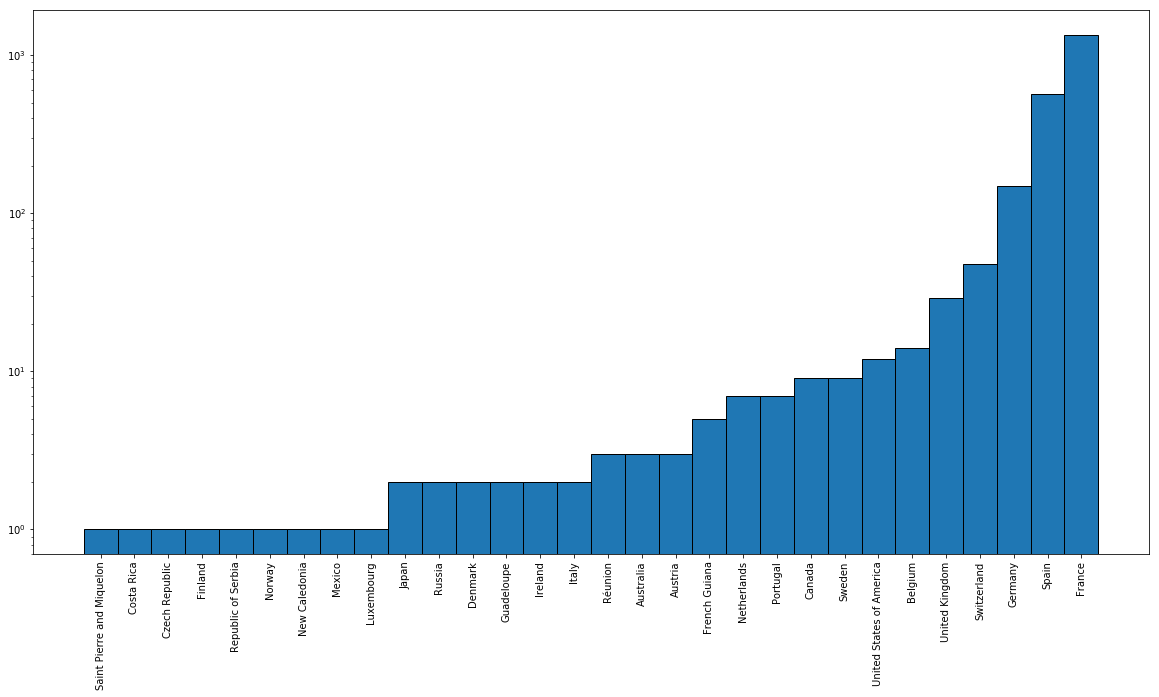

In [35]:
Legume = Complete_cleaned.groupby("pnns_groups_2").get_group('Legumes').country.value_counts()
legume = Complete_cleaned.groupby("pnns_groups_2").get_group('legumes').country.value_counts()
fruit = Complete_cleaned.groupby("pnns_groups_2").get_group('fruits').country.value_counts()
Fruit = Complete_cleaned.groupby("pnns_groups_2").get_group('Fruits').country.value_counts()
Vegetable = Complete_cleaned.groupby("pnns_groups_2").get_group('Vegetables').country.value_counts()
vegetable = Complete_cleaned.groupby("pnns_groups_2").get_group('vegetables').country.value_counts()

Vegetables = Vegetable
Vegetables = Vegetables.add(vegetable,fill_value=0)
Vegetables = Vegetables.add(Fruit,fill_value=0)
Vegetables = Vegetables.add(fruit,fill_value=0)
Vegetables = Vegetables.add(legume,fill_value=0)
Vegetables = Vegetables.add(Legume,fill_value=0)
Vegetables = Vegetables.sort_values()

fig,ax = plt.subplots(figsize=(20, 10))
ax.bar(Vegetables.index,Vegetables.values, align='center', width=1,log=True,edgecolor = "black")
plt.xticks(rotation=90);

This time we notice that it seems that there are more product with vegetables proposed in the countris in Europe. This is, however, not necessary the case, since it might be due to the fact that we have much more informations about the european countries than the other ones. 

In [36]:
# We create a dataframe from the previous pandas Series
Vegetables_df = pd.DataFrame({'country':Vegetables.index, 'vegetables':Vegetables.values})

In [37]:
Vegetables_df = AddMissingCountries(Vegetables_df,DATAPATH+"world-countries.json","vegetables")

In [42]:
Vegetables_dict = Vegetables_df.set_index('country')['vegetables']
world = plot_choropleth(Vegetables_dict, 'Quantity of products that are vegetables', 0, max(Vegetables_df["vegetables"]),5)

world

In the previous map, we firstly see that there are a lot of missing values (the grey on the map). Furthermore, we notice that we can only find a lot of product with vegetables in Europe. This could be explain as before, namely that there are a much more product from Europe than from the rest of the world on OpenFoodFact.

Finally we notice in South-America that one country is colored in red. This country is the French Guiana. This is not surprising since this part of South-America belongs to France and thus, the number of products will be the same for this region as for France. 

### Goals for the next milestone 